In [1]:
import os
import joblib
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import random
from modules.encoder import Encoder, Identity
from modules.function import pymatgen_comp, data_generator, check_cuda, stratify_data

/noether/s0/aqd5773/anaconda3/envs/monbw_alloy_hardness/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
saved_model_path = 'saved_models/hardness_models'
if not os.path.exists(saved_model_path):
  os.makedirs(saved_model_path)

In [4]:
gfa_dataset_file = 'gfa_dataset.txt'
z_row_column_file = 'Z_row_column.txt'
element_property_file = 'element_property.txt'
common_path = "Files_from_GTDL_paper/{}" 
gfa_dataset = pickle.load(open(common_path.format(gfa_dataset_file), 'rb'))  
RC = pickle.load(open(common_path.format(z_row_column_file), 'rb')) 
new_index=[int(i[4]) for i in RC]#new order 
Z_row_column = pickle.load(open(common_path.format(z_row_column_file), 'rb'))
[property_name_list,property_list,element_name,_]=pickle.load(open(common_path.format(element_property_file), 'rb'))

In [5]:
saved_models_path = 'saved_models'
type = 'PTR'
filename = 'PTR_Encoder_torch.pt'
if os.path.exists(f'{saved_models_path}/{type}/{filename}'):
    PTR_encoder =  torch.jit.load(f'{saved_models_path}/{type}/{filename}')
else:
    print('No file found!')


# Iteration 1 - Train with initial dataset, predict on all experimental values

In [6]:
initial_df_path = 'dataset/Hardness_CURATED_Dec2022_FixedElementsExcluded.csv'
df = pd.read_csv(initial_df_path)
df.columns = ['Composition','database','temperature','HardGPa']
df['HardGPa'] = df['HardGPa'].div(1e9)
data = df[['Composition','HardGPa']].values
comps = data[:,0]
hardGPa = data[:,1].reshape(-1,1)
pmg_comps = pymatgen_comp(comps)
comps_dset = data_generator(pmg_comps,property_list,element_name,RC)

In [7]:
enc_input = torch.from_numpy(comps_dset.real_data.astype('float32'))
cuda = check_cuda()
if cuda:
    enc_input = enc_input.cuda()
    PTR_encoder = PTR_encoder.cuda()
with torch.no_grad():
    PTR_features = PTR_encoder(enc_input).to('cpu').detach().numpy()

In [31]:
pca = PCA(n_components=10)
scaler_y = StandardScaler()
X = pca.fit_transform(PTR_features)
y = hardGPa

In [10]:
np.random.seed(0)
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'batch_size' : [32,64,128]
          }
gridCV = GridSearchCV(MLPRegressor(), param_grid=param_grid,cv=10)
pipe = Pipeline([('Scaler', StandardScaler()),('grid',gridCV)])
pipe.fit(X,y.ravel())
#joblib.dump(pipe,f'{saved_model_path}/MLP_hardness_iter0.pt')

Pipeline(steps=[('Scaler', StandardScaler()),
                ('grid',
                 GridSearchCV(cv=10, estimator=MLPRegressor(),
                              param_grid={'activation': ['relu', 'tanh',
                                                         'logistic'],
                                          'alpha': [0.0001, 0.05],
                                          'batch_size': [32, 64, 128],
                                          'hidden_layer_sizes': [(50, 50, 50),
                                                                 (50, 100, 50),
                                                                 (100, 1)],
                                          'learning_rate': ['constant',
                                                            'adaptive']}))])

In [19]:
pipe['grid'].best_params_

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 32,
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'adaptive'}

In [44]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=0, shuffle = True)
true, predict = [],[]
v = []
for i,(train_inds, test_inds) in enumerate(kf.split(X)):
    X_train, y_train = X[train_inds], y[train_inds].ravel()
    X_test, y_test = X[test_inds],y[test_inds].ravel()
    model = Pipeline([('Scaler', StandardScaler()),('mlp',MLPRegressor(activation = 'relu', alpha = 0.0001, batch_size = 32,hidden_layer_sizes = (50, 50, 50),learning_rate = 'adaptive'))])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    true.extend(y_test)
    predict.extend(y_pred)
    v.extend([i]*len(y_pred))
    with open(f'saved_models/hardness_models/iter0/mlp_{i}.pkl','wb') as fid:
        pickle.dump(model,fid)

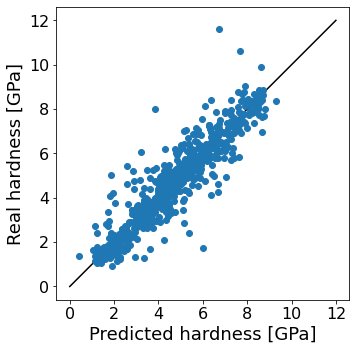

In [102]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (5,5))
ax.scatter(predict, true)
ax.plot([0,12], [0,12], 'k-', zorder=0)
ax.set_xlabel('Predicted hardness [GPa]', fontsize = 18)
ax.set_ylabel('Real hardness [GPa]', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_aspect('equal', adjustable='box')
ax.set_xticks(np.arange(0,14,2))
ax.set_yticks(np.arange(0,14,2))
fig.tight_layout()

fig_location = 'figures'
plt.savefig(fig_location+'/fit_new.pdf')


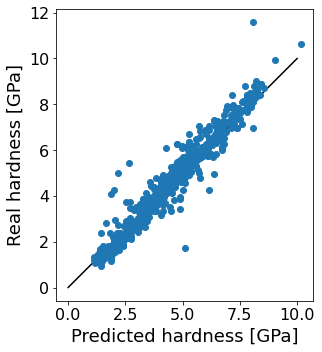

In [9]:
import joblib
import matplotlib.pyplot as plt
model = joblib.load('saved_models/hardness_models/MLP_hardness_iter0.pt')

predicted = model.predict(X)
scaled_predicted = scaler_y.inverse_transform(predicted.reshape(-1,1))
fig,ax = plt.subplots(figsize = (5,5))
ax.scatter(scaled_predicted,data[:,1].reshape(-1,1))
ax.plot([0,10], [0,10], 'k-', zorder=0)
ax.set_xlabel('Predicted hardness [GPa]', fontsize = 18)
ax.set_ylabel('Real hardness [GPa]', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_aspect('equal', adjustable='box')

fig_location = 'figures'
plt.tight_layout()
plt.savefig(fig_location+'/fit.pdf')

In [10]:
pipe = joblib.load(f'{saved_model_path}/MLP_hardness_iter0.pt')

In [45]:
experimental_df_path = 'dataset/experimental_hardness.csv'
experimental_df = pd.read_csv(experimental_df_path)

In [50]:
experimental_comps = experimental_df['Composition'].values
experimental_hardGPa = experimental_df['HardGPa'].values.reshape(-1,1)
experimental_pmg_comps = pymatgen_comp(experimental_comps)
experimental_comps_dset = data_generator(experimental_pmg_comps,property_list,element_name,RC)
exp_enc_input = torch.from_numpy(experimental_comps_dset.real_data.astype('float32'))
cuda = check_cuda()
if cuda:
    exp_enc_input = exp_enc_input.cuda()
exp_PTR_features = PTR_encoder(exp_enc_input).to('cpu').detach().numpy()
X_exp = pca.transform(exp_PTR_features)

In [19]:
exp_enc_input = torch.from_numpy(experimental_comps_dset.real_data.astype('float32'))
cuda = check_cuda()
if cuda:
    exp_enc_input = exp_enc_input.cuda()
exp_PTR_features = PTR_encoder(exp_enc_input).to('cpu').detach().numpy()
X_exp = pca.transform(exp_PTR_features)
y_exp_predict = np.round(scaler_y.inverse_transform(pipe.predict(X_exp).reshape(-1,1)),2)
experimental_df['Iteration 1 predictions'] = y_exp_predict

In [71]:
models = os.listdir('saved_models/hardness_models/iter0')
preds = []
for model_name in models:
    with open(os.path.join('saved_models/hardness_models/iter0',model_name),'rb') as fid:
        model = pickle.load(fid)
    preds.append(model.predict(X_exp))
all_preds = np.array(preds).T
preds_mean = all_preds.mean(axis=1)
preds_std = all_preds.std(axis=1)
preds_mean, preds_std
from uncertainties import ufloat
y_exp_predict = [ufloat(x,y) for x,y in zip(preds_mean, preds_std)]
experimental_df['Iteration 1 predictions'] = y_exp_predict


In [72]:
#experimental_df['percent error'] = (experimental_df['HardGPa'] - experimental_df['Iteration 1 predictions'])/experimental_df['HardGPa']*100
experimental_df

,Composition,HardGPa,Iteration 1 predictions
0,Nb0.37Mo0.52W0.11,5.2,3.4+/-1.0
1,Nb0.49Mo0.07W0.44,5.8,5.1+/-2.4
2,Nb0.57Mo0.33W0.10,5.4,3.8+/-1.9
3,Nb0.32Mo0.44W0.24,5.2,3.7+/-0.9
4,Nb0.425Mo0.167W0.407,6.0,4.3+/-2.1
5,Nb0.33Mo0.327W0.344,5.6,3.9+/-1.0
6,Nb0.17W0.32Zr0.18Ti0.32,4.9,2.4+/-0.7
7,Nb0.06Mo0.03W0.27Zr0.3Ti0.3V0.03,4.4,2.7+/-0.8
8,Nb0.47Mo0.13W0.07Zr0.17Ti0.03V0.13,5.0,4.0+/-0.9


In [15]:
experimental_df.to_csv('dataset/iterative_prediction.csv')

# Iteration 2 - Include first three experimental values in training model 

## a-c

In [74]:
PTR_features_new = np.concatenate([PTR_features,exp_PTR_features[:3]],axis=0)
hardGPa_new = np.concatenate([hardGPa,experimental_hardGPa[:3]],axis=0)
X_new = pca.transform(PTR_features_new)
y_new = hardGPa_new

In [76]:
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'batch_size' : [32,64,128]
          }
gridCV = GridSearchCV(MLPRegressor(), param_grid=param_grid,cv=10)
pipe = Pipeline([('Scaler', StandardScaler()),('grid',gridCV)])
pipe.fit(X_new,y_new.ravel())
#joblib.dump(pipe,f'{saved_model_path}/MLP_hardness_iter1.pt')

Pipeline(steps=[('Scaler', StandardScaler()),
                ('grid',
                 GridSearchCV(cv=10, estimator=MLPRegressor(),
                              param_grid={'activation': ['relu', 'tanh',
                                                         'logistic'],
                                          'alpha': [0.0001, 0.05],
                                          'batch_size': [32, 64, 128],
                                          'hidden_layer_sizes': [(50, 50, 50),
                                                                 (50, 100, 50),
                                                                 (100, 1)],
                                          'learning_rate': ['constant',
                                                            'adaptive']}))])

In [77]:
pipe['grid'].best_params_

{'activation': 'tanh',
 'alpha': 0.05,
 'batch_size': 32,
 'hidden_layer_sizes': (50, 100, 50),
 'learning_rate': 'constant'}

In [78]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=0, shuffle = True)
true, predict = [],[]
v = []
for i,(train_inds, test_inds) in enumerate(kf.split(X_new)):
    X_train, y_train = X_new[train_inds], y_new[train_inds].ravel()
    X_test, y_test = X_new[test_inds],y_new[test_inds].ravel()
    model = Pipeline([('Scaler', StandardScaler()),('mlp',MLPRegressor(activation = 'tanh', alpha = 0.05, batch_size = 32,hidden_layer_sizes = (50, 100, 50),learning_rate = 'constant'))])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    true.extend(y_test)
    predict.extend(y_pred)
    v.extend([i]*len(y_pred))
    with open(f'saved_models/hardness_models/iter1a/mlp_{i}.pkl','wb') as fid:
        pickle.dump(model,fid)

In [81]:
models = os.listdir('saved_models/hardness_models/iter1a')
preds = []
for model_name in models:
    with open(os.path.join('saved_models/hardness_models/iter1a',model_name),'rb') as fid:
        model = pickle.load(fid)
    preds.append(model.predict(X_exp))
all_preds = np.array(preds).T
preds_mean = all_preds.mean(axis=1)
preds_std = all_preds.std(axis=1)
preds_mean, preds_std
from uncertainties import ufloat
y_exp_predict = [ufloat(x,y) for x,y in zip(preds_mean, preds_std)]
experimental_df['Iteration 2 predictions'] = y_exp_predict

In [82]:
experimental_df

,Composition,HardGPa,Iteration 1 predictions,Iteration 2 predictions
0,Nb0.37Mo0.52W0.11,5.2,3.4+/-1.0,5.24+/-0.25
1,Nb0.49Mo0.07W0.44,5.8,5.1+/-2.4,5.70+/-0.17
2,Nb0.57Mo0.33W0.10,5.4,3.8+/-1.9,5.45+/-0.27
3,Nb0.32Mo0.44W0.24,5.2,3.7+/-0.9,5.17+/-0.28
4,Nb0.425Mo0.167W0.407,6.0,4.3+/-2.1,5.73+/-0.28
5,Nb0.33Mo0.327W0.344,5.6,3.9+/-1.0,5.20+/-0.31
6,Nb0.17W0.32Zr0.18Ti0.32,4.9,2.4+/-0.7,3.27+/-0.24
7,Nb0.06Mo0.03W0.27Zr0.3Ti0.3V0.03,4.4,2.7+/-0.8,3.11+/-0.30
8,Nb0.47Mo0.13W0.07Zr0.17Ti0.03V0.13,5.0,4.0+/-0.9,5.00+/-0.34


## d-f

In [84]:
PTR_features_new = np.concatenate([PTR_features,exp_PTR_features[3:]],axis=0)
hardGPa_new = np.concatenate([hardGPa,experimental_hardGPa[3:]],axis=0)
X_new = pca.transform(PTR_features_new)
y_new = hardGPa_new
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'batch_size' : [32,64,128]
          }
gridCV = GridSearchCV(MLPRegressor(), param_grid=param_grid,cv=10)
pipe = Pipeline([('Scaler', StandardScaler()),('grid',gridCV)])
pipe.fit(X_new,y_new.ravel())
#joblib.dump(pipe,f'{saved_model_path}/MLP_hardness_iter1b.pt')

Pipeline(steps=[('Scaler', StandardScaler()),
                ('grid',
                 GridSearchCV(cv=10, estimator=MLPRegressor(),
                              param_grid={'activation': ['relu', 'tanh',
                                                         'logistic'],
                                          'alpha': [0.0001, 0.05],
                                          'batch_size': [32, 64, 128],
                                          'hidden_layer_sizes': [(50, 50, 50),
                                                                 (50, 100, 50),
                                                                 (100, 1)],
                                          'learning_rate': ['constant',
                                                            'adaptive']}))])

In [85]:
pipe['grid'].best_params_

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 32,
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'constant'}

In [86]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=0, shuffle = True)
true, predict = [],[]
v = []
for i,(train_inds, test_inds) in enumerate(kf.split(X_new)):
    X_train, y_train = X_new[train_inds], y_new[train_inds].ravel()
    X_test, y_test = X_new[test_inds],y_new[test_inds].ravel()
    model = Pipeline([('Scaler', StandardScaler()),('mlp',MLPRegressor(activation = 'tanh', alpha = 0.0001, batch_size = 32,hidden_layer_sizes = (50, 50, 50),learning_rate = 'constant'))])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    true.extend(y_test)
    predict.extend(y_pred)
    v.extend([i]*len(y_pred))
    with open(f'saved_models/hardness_models/iter1b/mlp_{i}.pkl','wb') as fid:
        pickle.dump(model,fid)

In [87]:
models = os.listdir('saved_models/hardness_models/iter1b')
preds = []
for model_name in models:
    with open(os.path.join('saved_models/hardness_models/iter1b',model_name),'rb') as fid:
        model = pickle.load(fid)
    preds.append(model.predict(X_exp))
all_preds = np.array(preds).T
preds_mean = all_preds.mean(axis=1)
preds_std = all_preds.std(axis=1)
preds_mean, preds_std
from uncertainties import ufloat
y_exp_predict = [ufloat(x,y) for x,y in zip(preds_mean, preds_std)]
experimental_df['Iteration 2b predictions'] = y_exp_predict

In [88]:
experimental_df

,Composition,HardGPa,Iteration 1 predictions,Iteration 2 predictions,Iteration 2b predictions
0,Nb0.37Mo0.52W0.11,5.2,3.4+/-1.0,5.24+/-0.25,4.9+/-0.4
1,Nb0.49Mo0.07W0.44,5.8,5.1+/-2.4,5.70+/-0.17,5.4+/-0.7
2,Nb0.57Mo0.33W0.10,5.4,3.8+/-1.9,5.45+/-0.27,5.0+/-0.7
3,Nb0.32Mo0.44W0.24,5.2,3.7+/-0.9,5.17+/-0.28,5.11+/-0.11
4,Nb0.425Mo0.167W0.407,6.0,4.3+/-2.1,5.73+/-0.28,5.8+/-0.4
5,Nb0.33Mo0.327W0.344,5.6,3.9+/-1.0,5.20+/-0.31,5.36+/-0.21
6,Nb0.17W0.32Zr0.18Ti0.32,4.9,2.4+/-0.7,3.27+/-0.24,4.47+/-0.34
7,Nb0.06Mo0.03W0.27Zr0.3Ti0.3V0.03,4.4,2.7+/-0.8,3.11+/-0.30,4.0+/-0.4
8,Nb0.47Mo0.13W0.07Zr0.17Ti0.03V0.13,5.0,4.0+/-0.9,5.00+/-0.34,5.01+/-0.21


In [99]:
to_plot = experimental_df.iloc[:6,1:].values
to_plot[:,1][0].s

1.009074091911316

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

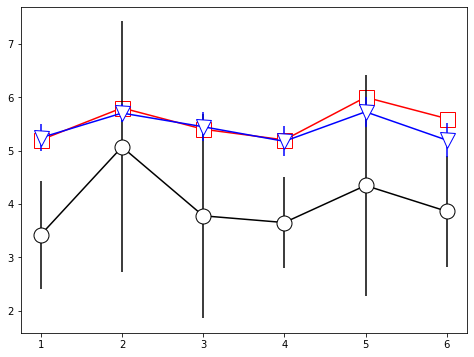

In [101]:
to_plot = experimental_df.iloc[:6,1:].values
fig,ax = plt.subplots(figsize = (8,6))
ax.plot(np.arange(1,7),to_plot[:,0], marker = 's', markersize = 15, c = 'red', markerfacecolor='white', label = 'Measured')
iter1_n = [x.n for x in to_plot[:,1]]
iter1_std = [x.s for x in to_plot[:,1]]
ax.errorbar(np.arange(1,7),iter1_n, yerr = iter1_std, marker = 'o', markersize = 15, c = 'black', markerfacecolor='white', label = 'Iteration 1')

iter2_n = [x.n for x in to_plot[:,2]]
iter2_std = [x.s for x in to_plot[:,2]]

ax.errorbar(np.arange(1,7),iter2_n,yerr=iter2_std, marker = 'v', markersize = 15, c = 'blue', markerfacecolor='white', label = 'Iteration 1')
ax.fill_between(np.arange(1,7), to_plot[:,0], iter1_n, color='pink', alpha=0.5)
ax.fill_between(np.arange(1,7), to_plot[:,0], iter2_n, color='green', alpha=0.5)
ax.set_xticks(np.arange(1,7), ['A','B','C','D','E','F'])
ax.tick_params(axis='x', which='major', labelsize=16, direction = 'in', size = 10)
ax.tick_params(axis='y', which='both', labelsize=16, direction = 'in', size = 10)
ax.set_ylim(1.5,6.5)
ax.set_xlabel('Sample', fontsize = 20)
ax.set_ylabel('Measured $H_{v}$ (GPa)', fontsize = 20)
plt.legend(fontsize="x-large", loc = 'lower right')
plt.savefig('figures/Fig7.jpeg')

In [90]:
experimental_df[:6].to_csv('final_predictions.csv')